### Loading Data

In [37]:
import numpy as np
import pandas as pd

DIR_PATH = "/kaggle/input/covid-segmentation/"
TRAIN_X_FILE = "images_medseg.npy"
TRAIN_Y_FILE = "masks_medseg.npy"

imgs_medseg = np.load(DIR_PATH+TRAIN_X_FILE).astype(np.float32)
msks_medseg = np.load(DIR_PATH+TRAIN_Y_FILE).astype(np.float32)

### Visualise the Images

In [38]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("dark_background")

def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples=8):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fix, ax = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))
    for i in range(num_samples):
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        ax_image.imshow(image_batch[i,:,:,0], cmap="Greys")
        ax_image.set_xticks([]) 
        ax_image.set_yticks([])
        
        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    mask_to_show = mask_batch[i,:,:,j]
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3)) 
                    mask_to_show[..., 0] = pred_batch[i,:,:,j] > 0.5
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([]) 
                ax[j + 1, i].set_yticks([]) 

    plt.tight_layout()
    plt.show()

**Description**
1. Actual Input
2. Mask for Ground Glass class
3. Mask for Consolidation class
4. Mask for Lungs Other class
5. Mask for Background Class

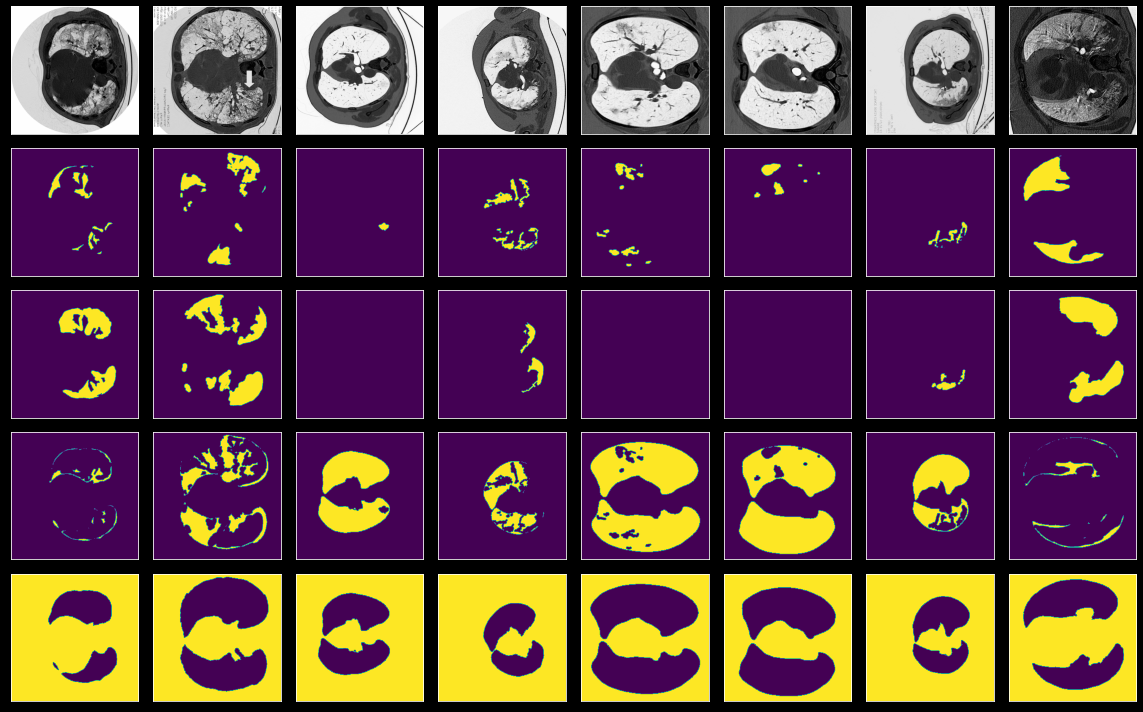

In [39]:
visualize(imgs_medseg, msks_medseg)

### Pixel Value Distribution Before Normalization

In [40]:
def plot_hists(images):
    plt.hist(images.ravel(), bins=100, density=True, color='b', alpha=1)

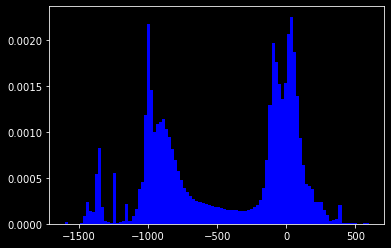

In [41]:
plot_hists(imgs_medseg)

### Normalizing Image Pixels

In [42]:
def normalize_img(img):
    img = img.astype("float32")
    img[img > 500] = 500
    img[img < -1500] = -1500
    min_perc, max_perc = np.percentile(img, 5), np.percentile(img, 95)
    img_valid = img[(img > min_perc) & (img < max_perc)]
    mean, std = img_valid.mean(), img_valid.std()
    img = (img-mean)/std
    return img

### Normalized Distribution of Pixels

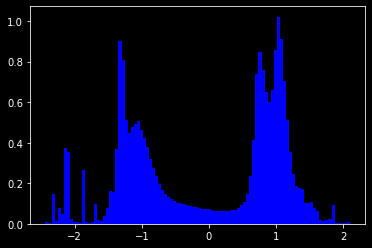

In [43]:
imgs_medseg = normalize_img(imgs_medseg)
plot_hists(imgs_medseg)

### Split training and validation data

In [44]:
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(imgs_medseg, msks_medseg, test_size=0.1, random_state=42)

### Building The UNET Architecture

In [45]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def convolution(input, num_filters):
  x = Conv2D(num_filters, 3, padding="same")(input)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(num_filters, 3, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  return x

def downsample(input, num_filters):
  x = convolution(input, num_filters)
  p = MaxPool2D((2,2))(x)
  return x, p

def upsample(input, skip_connections, num_filters):
  x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
  x = Concatenate()([x, skip_connections])
  x = convolution(x, num_filters)
  return x

def build_unet(input_shape):
  inputs = Input(input_shape)
  
  sc1, p1 = downsample(inputs, 64)
  sc2, p2 = downsample(p1, 128)
  sc3, p3 = downsample(p2, 256)
  sc4, p4 = downsample(p3, 512)

  b1 = convolution(p4, 1024)

  d1 = upsample(b1, sc4, 512)
  d2 = upsample(d1, sc3, 256)
  d3 = upsample(d2, sc2, 128)
  d4 = upsample(d3, sc1, 64)

  outputs = Conv2D(4,(1,1),padding="same",activation="softmax")(d4)

  model = Model(inputs, outputs, name="U-Net")
  return model

### IoU Metric Definition

In [46]:
def iou(true_y, pred_y):
    def f(true_y, pred_y):
        intersection = (true_y * pred_y).sum()
        union = true_y.sum() + pred_y.sum() - intersection
        x = (intersection)/(union)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [true_y, pred_y], tf.float32)

### Building Model

In [47]:
unet = build_unet(imgs_medseg.shape[1:])
unet.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc", iou])
results = unet.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=100, batch_size=1, verbose=1)

Epoch 1/100
90/90 [==============================] - 17s 165ms/step - loss: 0.5754 - acc: 0.6537 - iou: 0.3112 - val_loss: 0.4203 - val_acc: 0.6517 - val_iou: 0.4711
Epoch 2/100
90/90 [==============================] - 14s 159ms/step - loss: 0.2780 - acc: 0.8212 - iou: 0.5633 - val_loss: 7.3065 - val_acc: 0.3608 - val_iou: 0.2266
Epoch 3/100
90/90 [==============================] - 14s 159ms/step - loss: 0.1821 - acc: 0.8778 - iou: 0.7263 - val_loss: 6.1395 - val_acc: 0.7812 - val_iou: 0.6428
Epoch 4/100
90/90 [==============================] - 14s 158ms/step - loss: 0.1556 - acc: 0.8890 - iou: 0.7588 - val_loss: 0.4599 - val_acc: 0.6918 - val_iou: 0.5245
Epoch 5/100
90/90 [==============================] - 14s 159ms/step - loss: 0.1177 - acc: 0.9154 - iou: 0.8164 - val_loss: 0.1874 - val_acc: 0.8544 - val_iou: 0.6783
Epoch 6/100
90/90 [==============================] - 14s 158ms/step - loss: 0.1217 - acc: 0.9054 - iou: 0.7976 - val_loss: 0.1029 - val_acc: 0.9204 - val_iou: 0.8337
Epoc

90/90 [==============================] - 14s 158ms/step - loss: 0.0500 - acc: 0.9601 - iou: 0.9113 - val_loss: 0.0928 - val_acc: 0.9140 - val_iou: 0.8303
Epoch 51/100
90/90 [==============================] - 14s 159ms/step - loss: 0.0514 - acc: 0.9582 - iou: 0.9073 - val_loss: 0.0916 - val_acc: 0.9187 - val_iou: 0.8269
Epoch 52/100
90/90 [==============================] - 14s 159ms/step - loss: 0.0557 - acc: 0.9519 - iou: 0.8992 - val_loss: 0.1110 - val_acc: 0.9126 - val_iou: 0.8285
Epoch 53/100
90/90 [==============================] - 14s 159ms/step - loss: 0.0457 - acc: 0.9616 - iou: 0.9162 - val_loss: 0.0874 - val_acc: 0.9220 - val_iou: 0.8358
Epoch 54/100
90/90 [==============================] - 14s 159ms/step - loss: 0.0519 - acc: 0.9557 - iou: 0.9049 - val_loss: 0.1089 - val_acc: 0.8928 - val_iou: 0.7997
Epoch 55/100
90/90 [==============================] - 14s 159ms/step - loss: 0.0479 - acc: 0.9603 - iou: 0.9122 - val_loss: 0.1915 - val_acc: 0.7879 - val_iou: 0.6629
Epoch 56/10

90/90 [==============================] - 14s 159ms/step - loss: 0.0326 - acc: 0.9732 - iou: 0.9400 - val_loss: 0.1105 - val_acc: 0.8934 - val_iou: 0.8061
Epoch 100/100
90/90 [==============================] - 14s 159ms/step - loss: 0.0293 - acc: 0.9760 - iou: 0.9466 - val_loss: 0.0814 - val_acc: 0.9328 - val_iou: 0.8641


### Training Analytics

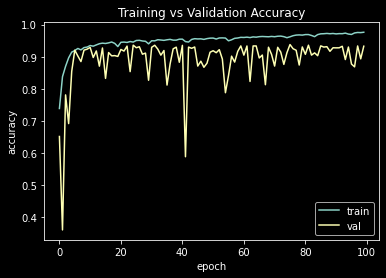

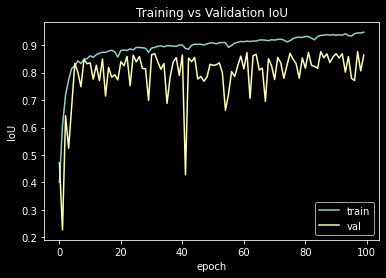

In [48]:
plt.figure(0)
plt.plot(results.history["acc"])
plt.plot(results.history["val_acc"])
plt.title("Training vs Validation Accuracy", color="white")

plt.xlabel("epoch", color="white")
plt.ylabel("accuracy", color="white")
plt.legend(["train", "val"])
plt.show()

plt.figure(1)
plt.plot(results.history["iou"])
plt.plot(results.history["val_iou"])
plt.title("Training vs Validation IoU", color="white")

plt.xlabel("epoch", color="white")
plt.ylabel("IoU", color="white")
plt.legend(["train", "val"])
plt.show()

### Segmented Output for Ground Glass

(10, 512, 512, 4)


<Figure size 432x288 with 0 Axes>

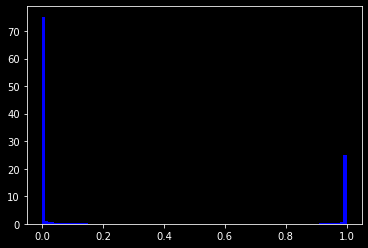

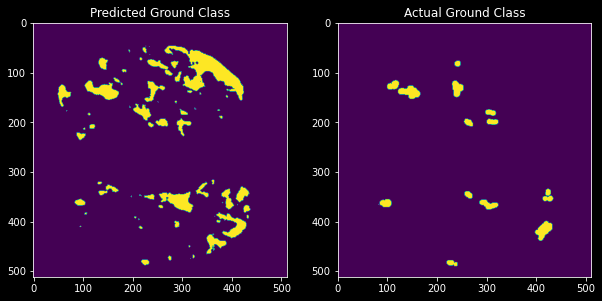

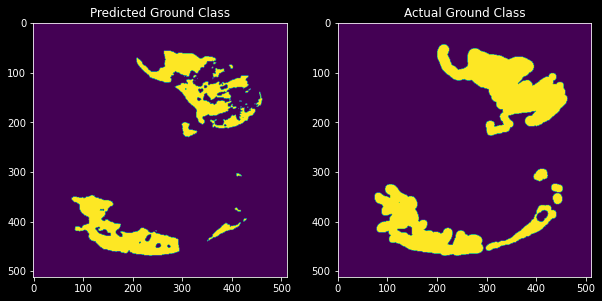

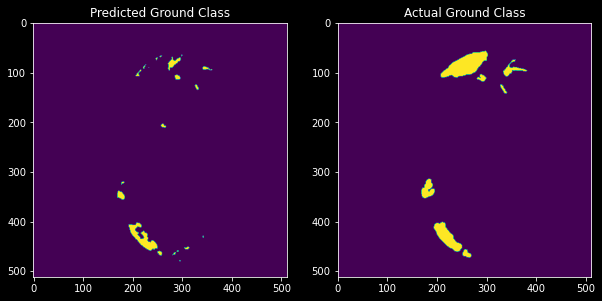

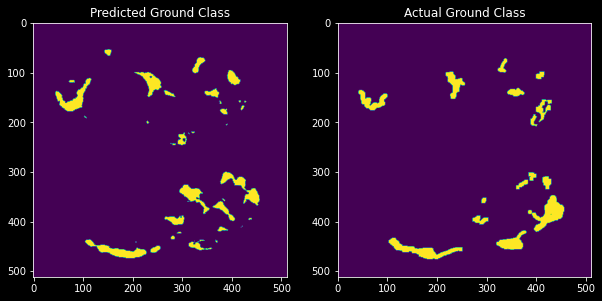

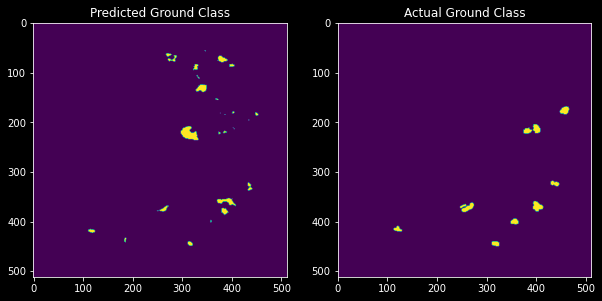

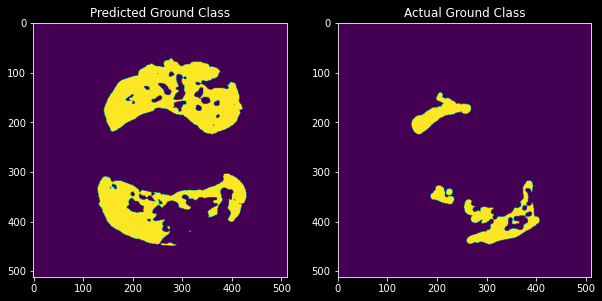

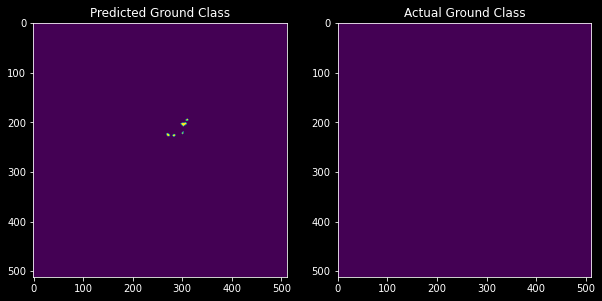

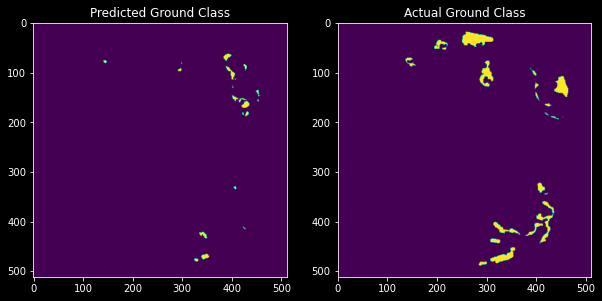

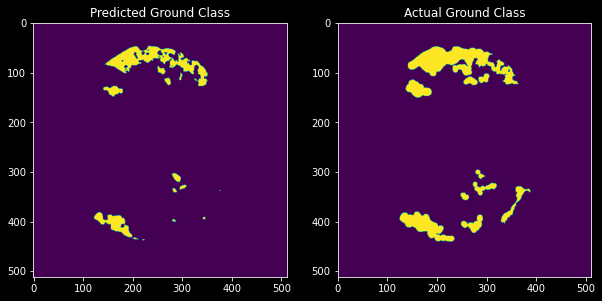

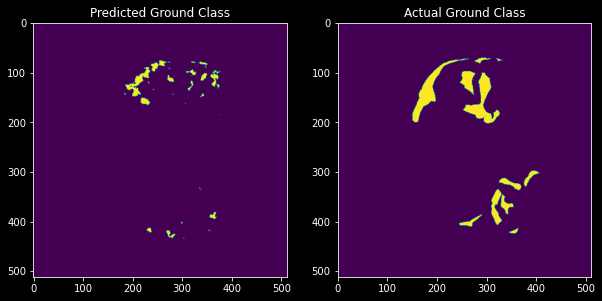

In [49]:
pred_y = unet.predict(val_x)
plot_hists(pred_y)

def filter_pixels(img):
    for i in range(img.shape[0]):
        for j in range(img.shape[3]):
            for k in range(img.shape[1]):
                for l in range(img.shape[2]):
                    img[i,k,l,j] = 1 if (img[i,k,l,j] > 0.5) else 0;
    return img

pred_y = filter_pixels(pred_y)
plot_hists(pred_y)

print(pred_y.shape)
for i in range(0, 10):
    plt.figure(i)
    fig, ax = plt.subplots(1,2, figsize=(10,10))
    ax[0].imshow(pred_y[i,:,:,0])
    ax[0].title.set_text("Predicted Ground Class")
    ax[1].imshow(val_y[i,:,:,0])
    ax[1].title.set_text("Actual Ground Class")